(chapter1_part2)=

# Baseline

Before we dive into some models, let's define the heuristic that must be beaten. It is not just the case for RecSys
the problem, but in all ML projects you better start with a definition of baseline to understand the efficiency of your model.
Sometimes it is the case that some heuristics-based algorithm will do the work and it is ok -- the goal is your
users and business value and having an exceptional ML model is not the goal at all.

There are various ways to generate baseline recommendations. One of them is to recommend popular items
based on some metrics like rating, and counters (watch times, number of purchases, clicks, etc.). Also,
we can use grouping based on user segments to make more accurate and relevant recommendations (to some extent, of course :)).
Here, we will use mean rating as a proxy for popularity and recommendations

In this chapter, I will walk through baseline recommender using [MovieLens Data](https://www.kaggle.com/code/quangnhatbui/movie-recommender/data)
For convenience, I uploaded it to Google Drive for centralized access for anyone. Below, there are the URLs of the main datasets that will be used
for the baseline recommender.

## 0. Configuration

In [1]:
# links to shared data MovieLens
RATINGS_SMALL_URL = 'http://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link'
MOVIES_METADATA_URL = 'http://drive.google.com/file/d/19g6-apYbZb5D-wRj4L7aYKhxS-fDM4Fb/view?usp=share_link'

## 1. Modules and functions
Now, let's import some libraries

In [2]:
# just to make it available to download w/o SSL verification
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import islice, cycle, product

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.2f' % x)


 and define 2 useful functinons 1) read_csv_from_gdrive() to get data from provided url of a file

In [3]:
def read_csv_from_gdrive(url):
    """
    gets csv data from a given url (taken from file -> share -> copy link)
    :url: example https://drive.google.com/file/d/1BlZfCLLs5A13tbNSJZ1GPkHLWQOnPlE4/view?usp=share_link
    """
    file_id = url.split('/')[-2]
    file_path = 'https://drive.google.com/uc?export=download&id=' + file_id
    data = pd.read_csv(file_path)

    return data

2nd one is compute_popularity() which calculates mean rating, sorts and returns top *K* required items

In [4]:
def compute_popularity(df: pd.DataFrame, item_id: str, max_candidates: int):
    """
    calculates mean rating to define popular titles
    """
    popular_titles = df.groupby(item_id).agg({'rating': np.mean})\
                     .sort_values(['rating'], ascending=False).head(max_candidates).index.values

    return popular_titles

## 2. Data
### 2.1 Load and Describe

Here, we will use two datasets:
- interactions -- refers to `RATINGS_SMALL_URL` where we have userId, movieId, timestamp and rating (our so-called target)
- movies_metadata -- refers to `MOVIES_METADATA_URL` where we have data all about movies - overview, genres etc.

In [5]:
# interactions data
interactions = read_csv_from_gdrive(RATINGS_SMALL_URL)
interactions.head()

,userId,movieId,rating,timestamp
0,1,31,2.50,1260759144
1,1,1029,3.00,1260759179
2,1,1061,3.00,1260759182
3,1,1129,2.00,1260759185
4,1,1172,4.00,1260759205


Let's get some statistics and look at ratings' distribution

In [6]:
interactions.describe()

,userId,movieId,rating,timestamp
count,100004.00,100004.00,100004.00,100004.00
mean,347.01,12548.66,3.54,1129639086.94
std,195.16,26369.20,1.06,191685826.03
min,1.00,1.00,0.50,789652009.00
25%,182.00,1028.00,3.00,965847824.00
50%,367.00,2406.50,4.00,1110421822.00
75%,520.00,5418.00,4.00,1296192495.50
max,671.00,163949.00,5.00,1476640644.00


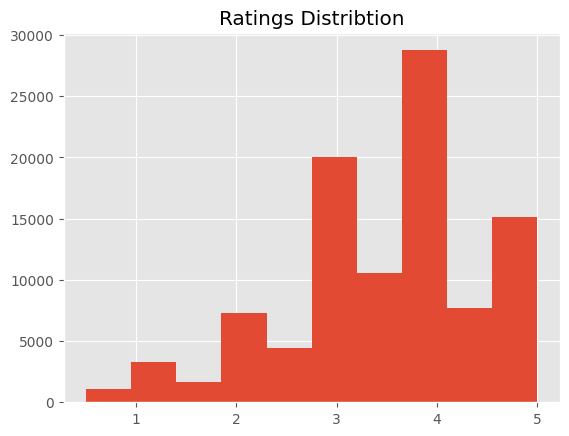

In [7]:
plt.style.use('ggplot')
interactions['rating'].hist();
plt.title('Ratings Distribtion');


We see that in most cases we have a 4 or 5 rating - the right tail is fatter.
Now, let's move on to movies metadata

In [8]:
# information about films etc
movies_metadata = read_csv_from_gdrive(MOVIES_METADATA_URL)

Which columns / info we have and their types - namings are pretty straightforward

In [9]:
movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

### 2.2. Data Preparation
Here, we will
- preprocess column names;
- set similar typing;
- leave movies in `interactions` that are present in `movies_metadata`;
- create users dataset for recommendatinos;
- movies name and movie mapper for convenience

First, we need to merge two dataframes and for that, it is necessary to make appropriate typing and column names for convenience.
The relationship between both datasets is set by movie id.

In [10]:
# align data in both dataframes to merge
interactions['movieId'] = interactions['movieId'].astype(str)
movies_metadata.rename(columns = {'id': 'movieId'}, inplace = True)

In [11]:
# leave only those films that intersect with each other
interactions_filtered = interactions.loc[interactions['movieId'].isin(movies_metadata['movieId'])]
print(interactions.shape, interactions_filtered.shape)

(100004, 4) (44989, 4)


In [12]:
# create users input
users = interactions[['userId']].drop_duplicates().reset_index(drop = True)

In [13]:
# create mapper for movieId and title names
item_name_mapper = dict(zip(movies_metadata['movieId'], movies_metadata['original_title']))

## 3. Model
Let's define our baseline popularity recommender BaselineRecommender - top-rated titles based on average rating with a possibility to get by any group(s)

The pipeline will be similar to most python ML modules -- it will have two methods in the end: fit() and recommend()

The logic of `fit()` as follow:
- Initiate recommendation based on a median rating from all observations recomm_common;
- Prepare a list of interacted items by users
- If we set groups - we get recommendations i.e. calculate movie ratings by groups:
    - If we get NaN, we fill it with base recommendations 
    - If we get less than the required number of candidates, we populate from base recommendations

The logic of `recommend()`:
- Return base recommendations if users data is not set;
- In the case of category wise requirements -- we get results of our fit

### 3.1. Fit
First, we define how many candidates we want to get

In [14]:
MAX_CANDIDATES = 20
ITEM_COLUMN = 'movieId'
USER_COLUMN = 'userId'

Then, we extract top 20 movies by aggregating movies and averaging rating column across all users

In [15]:
base_recommendations = compute_popularity(interactions_filtered, ITEM_COLUMN, MAX_CANDIDATES)
base_recommendations

array(['74727', '128846', '702', '127728', '65216', '43267', '8675',
       '80717', '86817', '8699', '872', '27724', '26791', '876', '64278',
       '301', '59392', '3021', '3112', '1933'], dtype=object)

Thus, we got 20 films with the highest average rating
Now, as we discussed earlier, in movie recommendations there is no need to recommend the same film which the user has already watched. Let's implement it as well
We get all interacted items for each user and save them in dictionary {'userId': [items list]}

In [16]:
known_items = interactions_filtered.groupby(USER_COLUMN)[ITEM_COLUMN].apply(list).to_dict()
print(f"Number of users with known items: {len(known_items)} \n")

# let's check it for one userId = 1
print(f"Example of known item ids for particaular user: {known_items[1]}")

Number of users with known items: 671 

Example of known item ids for particaular user: ['1371', '1405', '2105', '2193', '2294', '2455']


Now we have all the necessary components: base recommendations without groups with the possibility to filter already watched items
Also, if we want to get recommendations based on some user groups we can easily do the same with groupby() method and the same approach

In [17]:
# lets add artifical binary group to check BaselineRecommender
group = [np.random.random_integers(2) for x in range(len(users))]
users['group'] = group

Here we merge it to get groupwise recommendations

In [18]:
data = pd.merge(interactions_filtered, users, how='left', on = USER_COLUMN)
group_recommendations = data.groupby('group').apply(compute_popularity, ITEM_COLUMN, MAX_CANDIDATES)
group_recommendations.head()

group
1    [48791, 872, 632, 2927, 3575, 127728, 5473, 87...
2    [7096, 3133, 1819, 301, 80717, 1859, 2981, 764...
dtype: object

In the output, we have two rows with a list of film ids for each binary group 
Next, we have to implement `recommend()` method which will use 


### 3.2. Recommend
Earlier, we discussed that we can take just the average/median, etc. of rating and use it as a popularity metric to use as recommendations.
Thus, if we do not have groups to consider (a.k.a more granular estimation), then it means we give the same recommendations
for all users i.e. *base_recommendations*

In [19]:
recs = list(islice(cycle([base_recommendations]), len(users['userId'])))
users['rekkos'] = recs
users.head()

,userId,group,rekkos
0,1,2,"[74727, 128846, 702, 127728, 65216, 43267, 867..."
1,2,2,"[74727, 128846, 702, 127728, 65216, 43267, 867..."
2,3,2,"[74727, 128846, 702, 127728, 65216, 43267, 867..."
3,4,2,"[74727, 128846, 702, 127728, 65216, 43267, 867..."
4,5,2,"[74727, 128846, 702, 127728, 65216, 43267, 867..."


And let's have an example with groups we created earlier

In [20]:
group_recommendations = group_recommendations.reset_index()
group_rekkos = pd.merge(users, group_recommendations, how = 'left', on = 'group')
group_rekkos.rename(columns = {0: 'group_wise_rekkos'}, inplace = True)
group_rekkos.head()

,userId,group,rekkos,group_wise_rekkos
0,1,2,"[74727, 128846, 702, 127728, 65216, 43267, 867...","[7096, 3133, 1819, 301, 80717, 1859, 2981, 764..."
1,2,2,"[74727, 128846, 702, 127728, 65216, 43267, 867...","[7096, 3133, 1819, 301, 80717, 1859, 2981, 764..."
2,3,2,"[74727, 128846, 702, 127728, 65216, 43267, 867...","[7096, 3133, 1819, 301, 80717, 1859, 2981, 764..."
3,4,2,"[74727, 128846, 702, 127728, 65216, 43267, 867...","[7096, 3133, 1819, 301, 80717, 1859, 2981, 764..."
4,5,2,"[74727, 128846, 702, 127728, 65216, 43267, 867...","[7096, 3133, 1819, 301, 80717, 1859, 2981, 764..."


We got our groupwise recommendations from 3.1. part and just joined them by a group of users assigned to
Further, we will prettify our code and wrap it into functions

### 3.3. Wrap everything into pretty functions
#### 3.3.1. Fit Part

In this function, we need to support 4 main parameters
- data -- it is going to be pandas classic DataFrame;
- item_col -- the name of the item id column so we can apply it on any dataset;
- groups -- if we need groupwise recommendations;
- max_candidates -- the number of recommendations to return

Thus, our function will get a pandas data frame with necessary data, calculate popularity for a given type -
groupwise or not and return ids

In [21]:
def fit(
    data: pd.DataFrame,
    item_col: str,
    groups: list = None,
    max_candidates: int = 20
    ):
    """
    function runs all pipeline to generate recommendations based on given group
    :data: dataframe of interactions
    :item_col: item column name
    :groups: optional, list of groups column names to get recommendations
    :max_candidates: number of recommendations to return
    """
    
    if groups is not None:
        recommendations = data.groupby(groups).apply(compute_popularity, item_col, max_candidates)
    else:
        recommendations = compute_popularity(data, item_col, max_candidates)

    return recommendations

In [22]:
# check base recommendations
fit(data, item_col=ITEM_COLUMN)

array(['74727', '128846', '702', '127728', '65216', '43267', '8675',
       '80717', '86817', '8699', '872', '27724', '26791', '876', '64278',
       '301', '59392', '3021', '3112', '1933'], dtype=object)

In [23]:
# check group-wise
fit(data, item_col=ITEM_COLUMN, groups=['group'])

group
1    [48791, 872, 632, 2927, 3575, 127728, 5473, 87...
2    [7096, 3133, 1819, 301, 80717, 1859, 2981, 764...
dtype: object

#### 3.3.2. Recommend Part
Here, we just use calculated recommendations from the above method `fit()`

In [24]:
def recommend(
    users: pd.DataFrame,
    recommendations: pd.DataFrame,
    groups: list = None,
    K: int = 10
    ):
    """
    recommends items for a given list of users
    :users: series / list of users to recommend
    :recommendations: output of fit() function
    :groups: optional, list of groups column names to get recommendations
    :K: number of items to recommend (not always we want to show dozens of items instantly)
    """
    if groups is not None:
        output = pd.merge(users, recommendations.reset_index(), how = 'left', on = 'group')

    else:
        output = users.copy(deep = True)
        recs = list(islice(cycle([recommendations]), len(users['userId'])))
        output['rekkos'] = recs

    return output

In [25]:
# check base recommendations
recs = fit(data, item_col=ITEM_COLUMN)
check_recs = recommend(users[['userId', 'group']], recs)
check_recs.head()

,userId,group,rekkos
0,1,2,"[74727, 128846, 702, 127728, 65216, 43267, 867..."
1,2,2,"[74727, 128846, 702, 127728, 65216, 43267, 867..."
2,3,2,"[74727, 128846, 702, 127728, 65216, 43267, 867..."
3,4,2,"[74727, 128846, 702, 127728, 65216, 43267, 867..."
4,5,2,"[74727, 128846, 702, 127728, 65216, 43267, 867..."


In [26]:
# check group-wise
recs = fit(data, item_col=ITEM_COLUMN, groups = ['group'])
check_recs = recommend(users[['userId', 'group']], recs, ['group'])
check_recs.head()

,userId,group,0
0,1,2,"[7096, 3133, 1819, 301, 80717, 1859, 2981, 764..."
1,2,2,"[7096, 3133, 1819, 301, 80717, 1859, 2981, 764..."
2,3,2,"[7096, 3133, 1819, 301, 80717, 1859, 2981, 764..."
3,4,2,"[7096, 3133, 1819, 301, 80717, 1859, 2981, 764..."
4,5,2,"[7096, 3133, 1819, 301, 80717, 1859, 2981, 764..."


Congrats! Your first basic recommender system is ready!! In the next section, we will
dive into how to evaluate our model